# Part 1

## 1a Forward Euler solver

In [25]:
%load_ext autoreload
%autoreload 2
import util
import scipy as sp
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1bcd Running forward Euler with linear params

In [26]:
%load_ext autoreload
%autoreload 2
from scipy.io import wavfile
import matplotlib.pyplot as plt
import engutil

## Params from Python driven with 0.15Vrms pink noise
Bl=6.831384111697111
R_e=4.813896577382383
R_m=2.30601776771379
K_m=1714.9942000346673
L_e=0.00033049656807511955
M_m=0.019566105498948536

F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])
x0 = np.array([0,0,0])

G = np.array([
    1.0/L_e,
    0.0,
    0.0
])

x0 = np.array([
    0.0,
    0.0,
    0.0
])

minimum_fs = util.calculate_min_fs(F)
print(f"Minimum fs: {minimum_fs:.2f}")
fs = int(5*minimum_fs)

pink_noise_20Hz = util.generate_pink_noise(fs*10, fs, fmin=1)

u = pink_noise_20Hz

x = util.solve_forward_euler(F, G, u, x0, fs)
X = np.array([x[:,0], x[:,1], x[:,2]])

G_iu_forward, G_du_forward, G_vu_forward, f = util.welch(u, X, fs)

G_iu_mag_db_forward, G_iu_phase_forward, G_iu_mag_lin_forward  = engutil.tf_to_magphase(G_iu_forward)
G_du_mag_db_forward, G_du_phase_forward, G_du_mag_lin_forward  = engutil.tf_to_magphase(G_du_forward)
G_vu_mag_db_forward, G_vu_phase_forward, G_vu_mag_lin_forward  = engutil.tf_to_magphase(G_vu_forward)

# engutil.plot_bode(f, [(G_du_mag_db_forward, None)], legends=["$\\hat{G}_{du}$"], title="$\\hat{G}_{du}$")
# engutil.plot_bode(f, [(G_iu_mag_db_forward, None)], legends=["$\\hat{G}_{iu}$"], title="$\\hat{G}_{iu}$")
# engutil.plot_bode(f, [(G_vu_mag_db_forward, None)], legends=["$\\hat{G}_{vu}$"], title="$\\hat{G}_{vu}$")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Minimum fs: 7023.90
Simulating 351190 steps with Ts=0.0000284746s...
len: 351190
nperseg = 14047.6
len: 10.0
Num avg: 30.000854262771227
freq res: 1.5000427131385614


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Simulating 35119 steps with Ts=0.0000284746s...
Detected Fundamental: 35.12 Hz
Total harmonic distortion: 0.003017107126654128
Simulating 35119 steps with Ts=0.0000284746s...
freq_res: 7.0238
carrier: 702.38 Hz, modulator: 35.119 Hz)
n=-1: peak at 667.3 Hz with amplitude 0.0035
carrer at n=0: peak at 702.4Hz with amplitude 0.0035
n=1: peak at 737.5 Hz with amplitude 0.0035
TIMD: 81.64965809279697


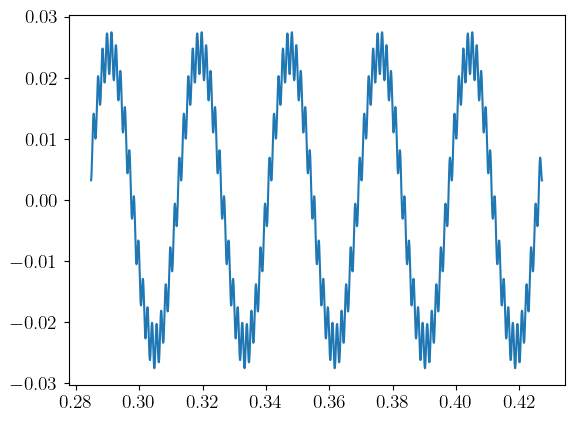

In [27]:
%load_ext autoreload
%autoreload 2
from scipy.io import wavfile
import matplotlib.pyplot as plt

duration = 1
freq = fs/1000
T = 1/freq
Vrms = 0.15

t = np.linspace(0,duration,int(duration*fs))
single_freq = np.sqrt(2)*Vrms*np.sin(2 * np.pi * freq * t)

x = util.solve_forward_euler(F, G, single_freq, x0, fs)

d_single = x[:,2]

# Snip t and d to avoid transient parts
t_snipped = t[int(10*fs*T):int(15*fs*T)]
d_single = d_single[int(10*fs*T):int(15*fs*T)]

thd_val, data = util.thd_r(d_single, fs)
print(f"Total harmonic distortion: {thd_val * 100}")

# plt.figure()
# plt.plot(t_snipped, d_single)

two_freq = np.sqrt(2)*Vrms*np.sin(2 * np.pi * freq * t) + np.sqrt(2)*Vrms*np.sin(2 * np.pi * 20*freq * t) 

x = util.solve_forward_euler(F, G, two_freq, x0, fs)

d_two_freq = x[:,2]

d_two_freq = d_two_freq[int(10*fs*T):int(15*fs*T)]

timd = util.timd(d_two_freq, fs, freq, 20*freq)
print(f"TIMD: {timd * 100}")

# util.save_wav("signals/two_freq.wav", two_freq, fs)

plt.figure()
plt.plot(t_snipped, d_two_freq)




## 1e Midpoint forward euler

len: 351190
nperseg = 14047.6
len: 10.0
Num avg: 30.000854262771227
freq res: 1.5000427131385614


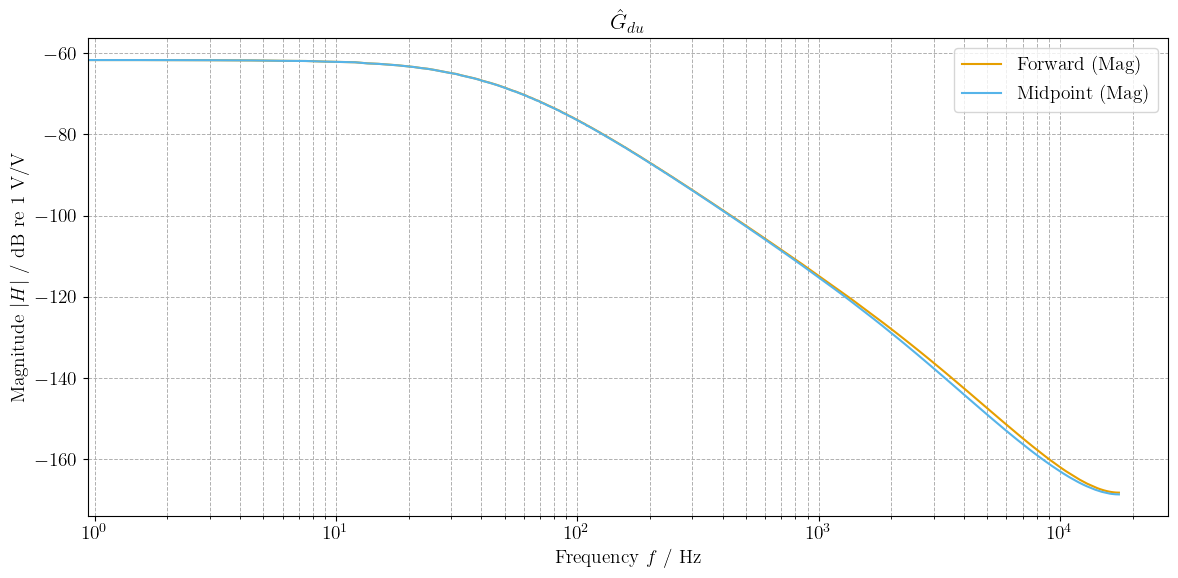

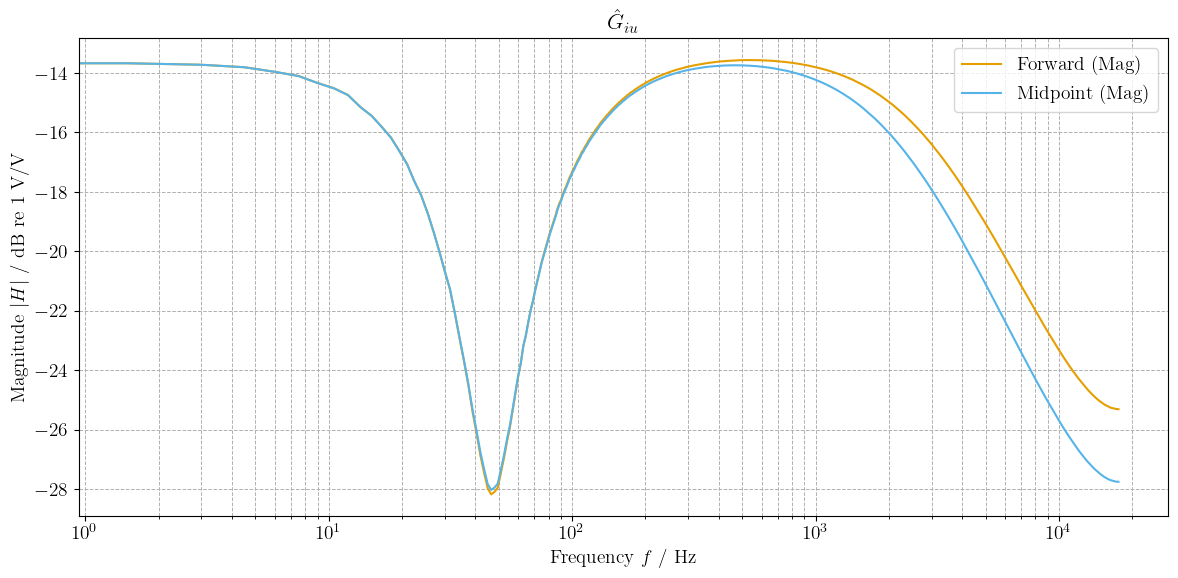

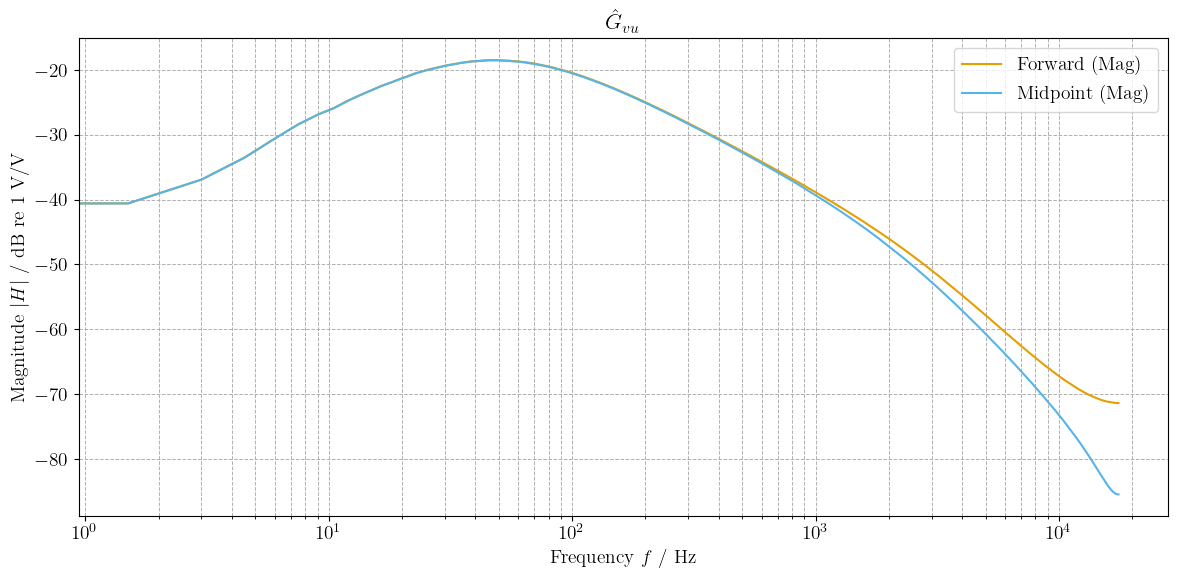

In [28]:
x = util.midpoint_forward_euler(F, G, u, x0, fs)
X = np.array([x[:,0], x[:,1], x[:,2]])

G_iu_midpoint, G_du_midpoint, G_vu_midpoint, f = util.welch(u, X, fs)

G_iu_mag_db_midpoint, G_iu_phase_midpoint, G_iu_mag_lin_midpoint  = engutil.tf_to_magphase(G_iu_midpoint)
G_du_mag_db_midpoint, G_du_phase_midpoint, G_du_mag_lin_midpoint  = engutil.tf_to_magphase(G_du_midpoint)
G_vu_mag_db_midpoint, G_vu_phase_midpoint, G_vu_mag_lin_midpoint  = engutil.tf_to_magphase(G_vu_midpoint)

# engutil.plot_bode(f, [(G_du_mag_db_midpoint, None)], legends=["$\\hat{G}_{du}$"], title="$\\hat{G}_{du}$")
# engutil.plot_bode(f, [(G_iu_mag_db_midpoint, None)], legends=["$\\hat{G}_{iu}$"], title="$\\hat{G}_{iu}$")
# engutil.plot_bode(f, [(G_vu_mag_db_midpoint, None)], legends=["$\\hat{G}_{vu}$"], title="$\\hat{G}_{vu}$")

engutil.plot_bode(f, [(G_du_mag_db_forward, None),(G_du_mag_db_midpoint, None)], legends=["Forward", "Midpoint"], title="$\\hat{G}_{du}$")
engutil.plot_bode(f, [(G_iu_mag_db_forward, None),(G_iu_mag_db_midpoint, None)], legends=["Forward", "Midpoint"], title="$\\hat{G}_{iu}$")
engutil.plot_bode(f, [(G_vu_mag_db_forward, None),(G_vu_mag_db_midpoint, None)], legends=["Forward", "Midpoint"], title="$\\hat{G}_{vu}$")



## Determine suitable $f_s$

In [ ]:
%load_ext autoreload
%autoreload 2

# klippel values (data/params.txt)
Bl=6.835564595969286
R_e=4.7800112854066175
R_m=2.499311244682717
K_m=1071.063439485575
L_e=0.0003256807665922887
M_m=0.019658990712765827

  
# example values from slides
R_e, L_e, Bl, M_m, R_m, K_m = 5, 0.0006, 7, 18e-3, 2, 1/0.0007


F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])

recommended_fs = util.calculate_min_fs(F)
print(recommended_fs)

util.check_stability(F, recommended_fs) 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3869.6821589946794
checking fs=3869.7 Hz => max eigenvalue magnitude: 1.0000


False

In [ ]:

# X = F + u*G
# state vector
# X = np.array([
#     i_n,
#     d_n,
#     v_n
# ])

# system matrix
F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])

# input matrix
G = np.array([
    [1.0/L_e],
    [0.0],
    [0.0]
])


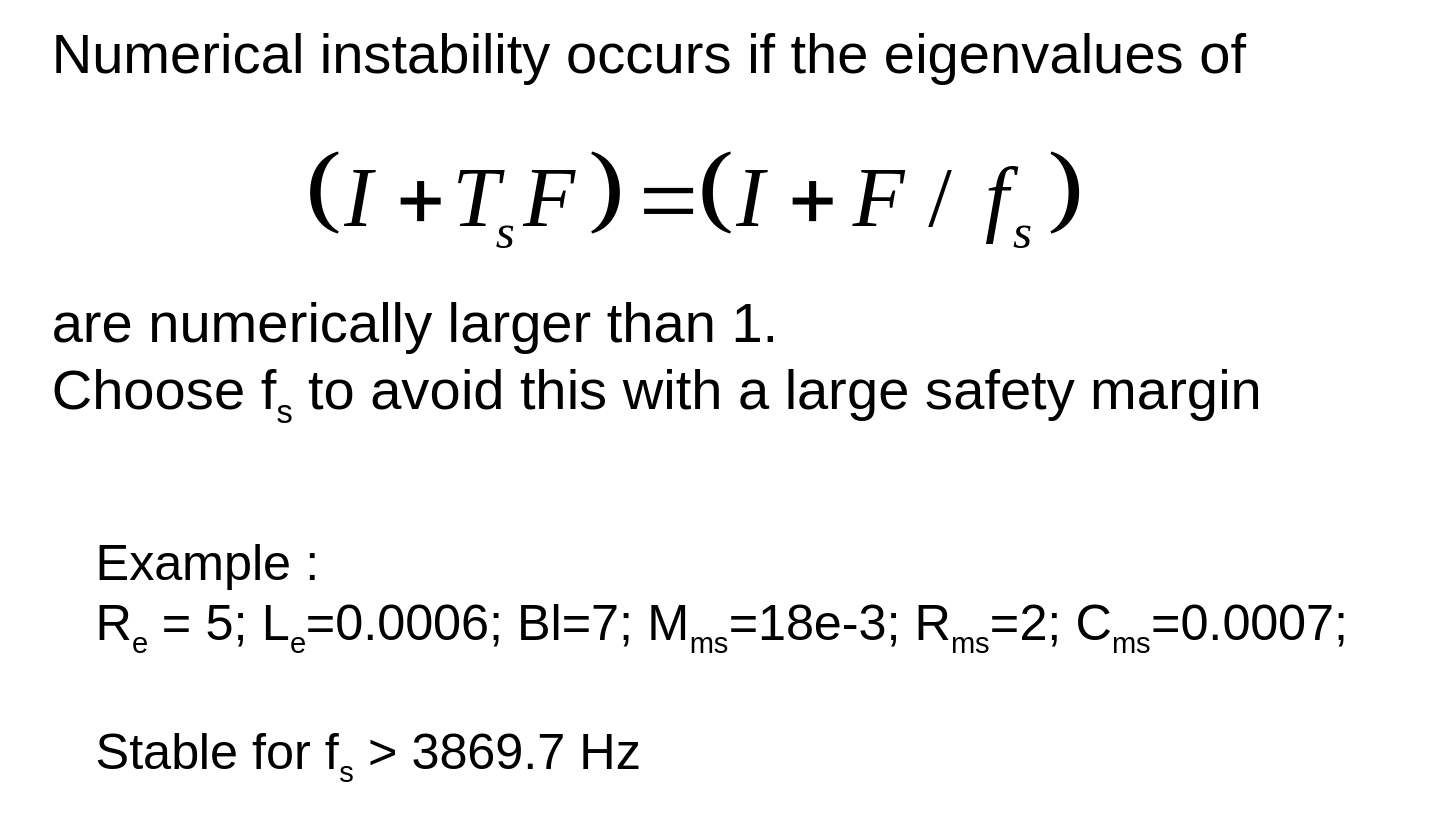